- 전처리된 excel / csv
    1. 실전db_after_2013.csv: 2013년 이후만 포함한 db 
    2. 강북_강남.xlsx: 처음 가격표 수기 작업시 excel로 작업한 db
    3. 지하철노선위경도정보3.xlsx 지하철목록db 출처(:)
    4. 가격데이터.csv 모두의 주차장 가격표 전처리 db
    5. price_column_added: A,B,C,D로 분류된 value에 값을 부여한 db

In [2]:
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
# plt.style.use('seaborn-whitegrid')
import os

In [3]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 <꼭> 재시작 해야함.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨짐.
        !apt-get update -qq
        !apt-get install fonts-nanum -qq  > /dev/null

        import matplotlib.font_manager as fm

        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family

In [4]:
# 시각화를 위한 폰트설정
# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당.
a = get_font_family()
# 폰트설정
import matplotlib.pyplot as plt 
plt.rc("font", family = a)
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)
# ggplot으로 그래프 스타일 설정
#plt.style.use("ggplot")


# Cohort

In [4]:
df = pd.read_csv('./과제/실전db.csv')

In [5]:
df = df[df["JOIN_DATE"]>="2013-01-01"]

In [6]:
temp2 = df.copy()

In [7]:
temp2.groupby(["USER_ID","DATE"])["COUNT"].count()

USER_ID  DATE      
224      2020-01-12    1
         2020-12-09    1
232      2020-01-19    1
         2020-01-26    1
         2020-01-27    1
                      ..
1830551  2020-12-31    1
1830570  2020-12-31    1
1830580  2020-12-31    1
1830589  2020-12-31    1
1830598  2020-12-31    1
Name: COUNT, Length: 878178, dtype: int64

In [8]:
temp2.drop(['JOIN_DATE','D_TYPE','STORE_ID','GOODS_TYPE','AD1'],
        axis=1,inplace=True)
temp2.head()

,USER_ID,DATE,COUNT
0,2858,2020-01-01,1
1,5647,2020-01-01,1
2,33314,2020-01-01,1
3,37001,2020-01-01,1
4,37819,2020-01-01,1


In [9]:
temp2["COUNT"].sort_values(ascending=False)

729776    61
748372    59
751974    58
726277    55
767392    53
          ..
583528     1
583527     1
583526     1
583525     1
0          1
Name: COUNT, Length: 878178, dtype: int64

In [10]:
temp2[temp2["COUNT"] == 61]

,USER_ID,DATE,COUNT
729776,999665,2020-11-07,61


## 1. 사용일자(DATE) 칼럼으로 단위 기간 만들기

In [11]:
temp2["DATE"]=pd.to_datetime(temp2["DATE"])

In [12]:
# DATE컬럼 데이터를 시계열 데이터로 만들고 새로운 컬럼 추가. 
temp2['OrderPeriod']=temp2['DATE'].dt.strftime('%Y-%m')

## 2. 유저의 첫번째 사용일 토대로 유저별 코호트 그룹 설정하기
- 동일한 경험이란 첫 번째 사용일.
- 각각의 raw에 고객ID별 첫 번째 주문일자를 추가.

In [13]:
temp2.set_index('USER_ID',inplace=True)
temp2.head()

,DATE,COUNT,OrderPeriod
USER_ID,,,
2858,2020-01-01,1,2020-01
5647,2020-01-01,1,2020-01
33314,2020-01-01,1,2020-01
37001,2020-01-01,1,2020-01
37819,2020-01-01,1,2020-01


In [14]:
FirstOrder=temp2.groupby(temp2.index)['DATE'].min()
FirstOrder.head()

USER_ID
224   2020-01-12
232   2020-01-19
342   2020-10-31
565   2020-08-27
729   2020-09-05
Name: DATE, dtype: datetime64[ns]

In [15]:
FirstOrder=FirstOrder.dt.strftime('%Y-%m')
FirstOrder.head()

USER_ID
224    2020-01
232    2020-01
342    2020-10
565    2020-08
729    2020-09
Name: DATE, dtype: object

In [16]:
temp2['FirstOrder']=FirstOrder
temp2.reset_index(inplace=True)
temp2.head()

,USER_ID,DATE,COUNT,OrderPeriod,FirstOrder
0,2858,2020-01-01,1,2020-01,2020-01
1,5647,2020-01-01,1,2020-01,2020-01
2,33314,2020-01-01,1,2020-01,2020-01
3,37001,2020-01-01,1,2020-01,2020-01
4,37819,2020-01-01,1,2020-01,2020-01


In [17]:
temp2[temp2["USER_ID"] == 33314]

,USER_ID,DATE,COUNT,OrderPeriod,FirstOrder
2,33314,2020-01-01,1,2020-01,2020-01
235092,33314,2020-05-01,1,2020-05,2020-01
238746,33314,2020-05-03,1,2020-05,2020-01


## 3. 코호트 그룹과 주문기간으로 데이터 집계하기


In [18]:
grouped = temp2.groupby(['FirstOrder', 'OrderPeriod'])

In [19]:
cohorts=grouped['USER_ID'].nunique()

In [20]:
cohorts=cohorts.reset_index()

In [21]:
cohorts.rename({'USER_ID':'TotalUsers'},axis=1,inplace=True)
cohorts.head()

,FirstOrder,OrderPeriod,TotalUsers
0,2020-01,2020-01,26369
1,2020-01,2020-02,9404
2,2020-01,2020-03,6886
3,2020-01,2020-04,7060
4,2020-01,2020-05,7202


In [22]:
each_period=cohorts['FirstOrder'].value_counts().sort_index()
each_period

2020-01    12
2020-02    11
2020-03    10
2020-04     9
2020-05     8
2020-06     7
2020-07     6
2020-08     5
2020-09     4
2020-10     3
2020-11     2
2020-12     1
Name: FirstOrder, dtype: int64

In [23]:
cohortperiod=[]

for x in each_period: 
    for y in range(x):
        cohortperiod.append(y)

In [24]:
cohorts['CohortPeriod']=cohortperiod
cohorts.head()

,FirstOrder,OrderPeriod,TotalUsers,CohortPeriod
0,2020-01,2020-01,26369,0
1,2020-01,2020-02,9404,1
2,2020-01,2020-03,6886,2
3,2020-01,2020-04,7060,3
4,2020-01,2020-05,7202,4


In [25]:
cohorts.set_index(['FirstOrder','CohortPeriod'],inplace=True)
cohorts.head()

OrderPeriod  TotalUsers
FirstOrder CohortPeriod                        
2020-01    0                2020-01       26369
           1                2020-02        9404
           2                2020-03        6886
           3                2020-04        7060
           4                2020-05        7202

In [26]:
cohorts=cohorts['TotalUsers'].unstack(1)
cohorts

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
FirstOrder,,,,,,,,,,,,
2020-01,26369.0,9404.0,6886.0,7060.0,7202.0,6592.0,6672.0,5836.0,5008.0,5821.0,5479.0,3882.0
2020-02,15285.0,4178.0,3683.0,3583.0,3244.0,3231.0,2858.0,2450.0,2762.0,2593.0,1923.0,NaN
2020-03,12565.0,3928.0,3231.0,2780.0,2757.0,2413.0,2209.0,2346.0,2083.0,1645.0,NaN,NaN
2020-04,12847.0,3532.0,2864.0,2774.0,2308.0,1971.0,2261.0,1946.0,1446.0,NaN,NaN,NaN
2020-05,13798.0,3539.0,3072.0,2458.0,2069.0,2415.0,2112.0,1459.0,NaN,NaN,NaN,NaN
2020-06,13148.0,3616.0,2699.0,2162.0,2353.0,2159.0,1449.0,NaN,NaN,NaN,NaN,NaN
2020-07,13959.0,3367.0,2459.0,2612.0,2342.0,1550.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08,11908.0,2783.0,2498.0,2158.0,1606.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,10158.0,2922.0,2224.0,1636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
user_retention=cohorts.divide(cohorts[0],axis=0)
user_retention


CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
FirstOrder,,,,,,,,,,,,
2020-01,1.0,0.356631,0.261140,0.267739,0.273124,0.249991,0.253024,0.221320,0.189920,0.220752,0.207782,0.147218
2020-02,1.0,0.273340,0.240955,0.234413,0.212234,0.211384,0.186981,0.160288,0.180700,0.169643,0.125810,NaN
2020-03,1.0,0.312614,0.257143,0.221250,0.219419,0.192041,0.175806,0.186709,0.165778,0.130919,NaN,NaN
2020-04,1.0,0.274928,0.222931,0.215926,0.179653,0.153421,0.175994,0.151475,0.112555,NaN,NaN,NaN
2020-05,1.0,0.256486,0.222641,0.178142,0.149949,0.175025,0.153066,0.105740,NaN,NaN,NaN,NaN
2020-06,1.0,0.275023,0.205278,0.164436,0.178963,0.164207,0.110207,NaN,NaN,NaN,NaN,NaN
2020-07,1.0,0.241206,0.176159,0.187119,0.167777,0.111039,NaN,NaN,NaN,NaN,NaN,NaN
2020-08,1.0,0.233708,0.209775,0.181223,0.134867,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,1.0,0.287655,0.218941,0.161055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


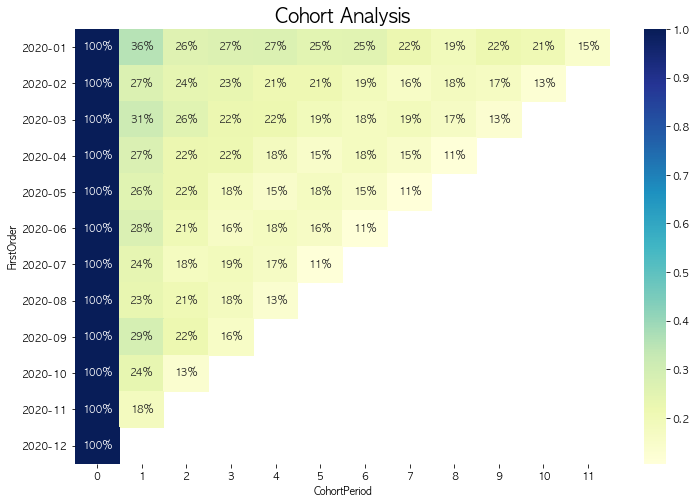

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.figure(figsize=(12, 8))
plt.title('Cohort Analysis', fontsize=19)
sns.heatmap(user_retention, cmap ="YlGnBu", annot=True, fmt='.0%')
plt.show()

# Cohort Analysis를 통한 Insight
## 1. Cohort Analysis Chart
- 2020.1월 사용자의 경우 잔존률(User retention)이 11개월의 걸쳐 36%에서 15%까지 하락하였음
- 반면에 2020.11 그룹의 경우 1개월만에 18%로 하락하였음

## 2. 문제점 
- Cohort 분석 결과 Product Life Cycle 안좋다는 것을 알게 되었음

## 3. 개선 방향
- 새로운 상품이 유입보다는 현 상품의 집중할 필요가 있음
- 현재 운영중인 상품에 대한 고객의 긍정적 경험을 주려는 노력이 필요함
- Product Life Cycle의 개선이 곧 User Life Cycle 개선으로 이어질 것으로 예상


<!-- # 인싸이트 적기
- 첫 번째 cohort그룹의 두 번째 달의 유저 라이프 싸이클이 36%에서 15%까지 떨어지는데 11개월 걸렸다. 그러나 11번째의 cohort그룹은 한달만에 10%대로 떨어졌다. Product Life Cycle이 안좋다는 것을 의미한다.
- Team1은 모두의 주차장이 프로덕트 라이프 싸이클을 살리기 위해선 현 프러턱트와 연계되는 새로운 아이템 또는 고객을 늘리기위한 이벤트성 마케팅 보다는 프러덕트 자체를 개선함으로써 고객 경험을 긍정적으로 바꾸어야 한다고 생각했다. 
- 개선할 점이 무엇인가를 알아보기 위해서 직접 고객이 되어 사용해보려고 가입도 해보고 팀원중 한명의 거주지를 등록하려는 시도 또한 해보았다. 
- 막상 원하는 지역의 주차장을 찾기는 많이 어려웠다(정보 인프라 부족). 모두의 주차장의 현 단계의 가장 중요한 고객은 단순히 충전금액을 지불하는 고객 보다는 주차장을 제공하는 사업자라고 생각했다. 쿠팡이 처음 배달 시장을 잠식할때 배달원과 사업자들에게 현금성 payback과 같은 incentive를 지불하면서 인프라를 만들고 그 인프라 위해 많은 고객을 유치했던것과 같은 맥락이라고 생각한다. 그렇게 하기 위해선 예산 최적화가 가장 중요할 것 같다고 생각했다. 
- 팀원의 의견은 프러덕트 라이프 싸이클이 좋아지면 자연스럽게 유저라이프 싸이클도 좋아질거라 의견을 모았다. 요즘 구글, 애플과 같이 고객 CS에 비중을 두어 고객을 관리하기보다는 고객이 쓸 수 밖에 없는 아이템을 만들고 사실 고객 스스로 제품을 learning하여 CS가 필요가 없는 구조를 만드는게 추세라고 판단했기 때문이다. 
- 다만 CS가 없는 대신 CS를 고려학 개발 환경은 중요하다고 생각한다. 구글 스토어에서 모두의 주차장의 댓글을 읽어보면 회원 가입 에러, 공유 시간대 설정과 같은 불편을 겪는 경우가 많이 올라오는 것을 확인했다. 고객군에서 건강한 고객군에게 UX/UI를 A/B테스트 해보며 최적의 Front를 엔지니어링하는것이 필요하다라고 본다. 
- 또한 할인 쿠폰에 대해 직원의 주차장에게 설명을 들었지만 (직원 또한 정확히 설명을 해주지 않았지만 이해한 바로는 주차장을 제공하는 쪽에서 할인 쿠폰을 발행하고 해당 지역을 자주 사용하는 고객에게 할인쿠폰을 랜덤으로 제공하는 방식.) 굳이 필요한 옵션인가 싶었다. 모두의 주차장을 로그인 하면 "내 주차권", "쿠폰함","충전금","적립금" 크게 4개의 카테고리로 수입을 얻는다. 우리 팀이 이해한 쿠폰발행 방식이라면 주차공간을 제공하는 사업자가 수입을 창출하기 위해서 적극적으로 쿠폰을 고객에게 발행할거라고 판단하지 않았다. 
- 가장 시급한 부분은 불법주차 부분이다. 불법주차를 해결하기 위해선 불법주차에 대한 시간대 컬럼, 장소 컬럼에 대한 정보가 필요하다고 생각한다. 데이터를 모으기 위해 가장 쉬운 방법은 고객들이 찾고 신고하는 제도라고 생각한다. 서비스를 구매하고 이용하는 고객이 불법주차로 인해 주차를 못댄다면 본인이 구매한 서비스 금액과 시간, 감정에대한 incentive를 제공하고 신고제도를 운영함으로써 불법주차에 대한 데이터를 모으면 패턴을 발견할 수 있을거라고 생각한다. 패턴을 발견하면 해당 패턴을 개선하는 KPI를 구성하고 팀원들과 회의를 해서 개선하면 좋겠다는 생각이 든다. -->

# RFM

In [5]:
os.listdir("./과제")

['실전db.csv',
 '디지털 스킬셋 기술과제.docx',
 '2020교통량통합.xlsx',
 '실전db_after_2013.csv',
 '지하철노선위경도정보3.xlsx',
 '서울시_기상데이터.csv',
 '강북_강남.xlsx']

In [5]:
df = pd.read_csv("./과제/실전db_after_2013.csv")

In [6]:
df.drop(['Unnamed: 0',"JOIN_YNM","JOIN_YEAR","D_TYPE","STORE_ID","AD1"], axis=1, inplace=True)

In [7]:
df

,USER_ID,JOIN_DATE,GOODS_TYPE,DATE,COUNT
0,2858,2014-01-07,A,2020-01-01,1
1,5647,2014-02-14,A,2020-01-01,1
2,33314,2014-11-20,A,2020-01-01,1
3,37001,2014-12-04,C,2020-01-01,1
4,37819,2014-12-07,C,2020-01-01,1
...,...,...,...,...,...
878173,1830551,2020-12-31,B,2020-12-31,1
878174,1830570,2020-12-31,B,2020-12-31,1
878175,1830580,2020-12-31,B,2020-12-31,1
878176,1830589,2020-12-31,B,2020-12-31,1


## 1. Recency Generated

In [8]:
temp_recency_df = df[["USER_ID","DATE"]]
recency_df = temp_recency_df.groupby("USER_ID")["DATE"].max().reset_index()
recency_df = recency_df.rename(columns={"DATE":"Recency"})

## 2. Frequency Generated

In [9]:
temp_frequency_df = df[["USER_ID","DATE"]].drop_duplicates()
frequency_df = temp_frequency_df.groupby("USER_ID")["DATE"].count().reset_index()
frequency_df = frequency_df.rename(columns={"DATE":"Frequency"})

## 3. Monetary Generated

### 3-1. 모두의 주차장 가격표 전처리

In [10]:
df = pd.read_csv("./과제/실전db_after_2013.csv")

In [11]:
df.drop(['Unnamed: 0',"JOIN_YNM","JOIN_YEAR","D_TYPE","STORE_ID","AD1"], axis=1, inplace=True)

In [12]:
df_price = pd.read_excel('./과제/강북_강남.xlsx')

In [13]:
df_price.columns

Index(['지하철역', '평일당일권', 'Unnamed: 2', '2시간권', '3시간권', '4시간권', '평일5시간권', '6시간권',
       '12시간권', '24시간권', '주간권', '공유 주차장', '월주차'],
      dtype='object')

In [14]:
df_price["지하철역"] = df_price["지하철역"].fillna(method='ffill')

In [15]:
df_price.head()

,지하철역,평일당일권,Unnamed: 2,2시간권,3시간권,4시간권,평일5시간권,6시간권,12시간권,24시간권,주간권,공유 주차장,월주차
0,구파발역,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,연신내역,9900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100000.0
2,독바위역,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,불광역,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70000.0
4,불광역,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180000.0


In [16]:
df_price.drop(["Unnamed: 2"], axis=1, inplace=True)

In [17]:
df_price.fillna(0, inplace=True)

In [18]:
df_price.columns

Index(['지하철역', '평일당일권', '2시간권', '3시간권', '4시간권', '평일5시간권', '6시간권', '12시간권',
       '24시간권', '주간권', '공유 주차장', '월주차'],
      dtype='object')

In [19]:
df_metroname_1 = df_price["지하철역"].unique()
display(df_metroname_1)

array(['구파발역', '연신내역', '독바위역', '불광역', '구산역', '역촌역', '응암역', '녹번역', '새절역',
       '증산역', '수색역', '디지털미디어시티역', '홍제역', '무약재역', '마포구청역', '독립문역', '망원역',
       '합정역', '홍대입구역', '상수역', '신촌역', '서강대역', '광흥창역', '대흥역', '이대역', '공덕역',
       '마포역', '효창공원앞역', '신용산역', '이촌역', '서빙고역', '녹사평역', '삼각지역', '남영역',
       '숙대입구역', '서울역', '애오개역', '아현역', '충정로역', '서대문역', '시청역', '회현역', '명동역',
       '을지로입구역', '종각역', '광화문역', '경복궁역', '안국역', '종로3가역', '종로5가역', '을지로3가역',
       '을지로4가역', '충무로역', '동대입구역', '동대문역사문화공원역', '용산역', '이태원역', '한강진역',
       '한남역', '옥수역', '버티고개역', '약수역', '금호역', '청구역', '신금호역', '동대문역', '신당역',
       '동묘앞역', '상왕십리역', '신설동역', '창신역', '혜화역', '한성대입구역', '성신여대입구역', '정릉역',
       '북한산보국문역', '길음역', '보문역', '안양역', '고려대역', '월곡역', '솔샘역', '삼양역', '화계역',
       '삼양사거리역', '미아역', '미아사거리역', '상월곡역', '돌곶이역', '수유역', '4.19민주묘지역',
       '솔밭공원역', '북한산우이역', '도봉산역', '도봉역', '방학역', '창동역', '쌍문역', '녹천역',
       '마들역', '당고개역', '상계역', '노원역', '중계역', '하계역', '월계역', '공릉역', '광운대역',
       '석계역', '태릉입구역', '화랑대역', '봉화산역', '먹골역', '중화역', '중

In [20]:
df_metro = pd.read_excel('./과제/지하철노선위경도정보3.xlsx')

In [21]:
df_metroname_2 = df_metro["역이름"].unique()

In [22]:
count = 0
undone_list = []
for x in df_metroname_2:
    if x in df_metroname_1:
        pass
    else:
        print(x)
        count += 1
        undone_list.append(x)
print(count)        

4·19민주묘지역
가락시장역
가산디지털단지역
가양역
가오리역
가좌역
강남역
강동구청역
강동역
개롱역
개봉역
개포동역
개화산역
거여역
경찰병원역
고덕역
고속터미널역
공항시장역
교대역
구로디지털단지역
구로역
구룡역
구반포역
구의역
구일역
국회의사당역
굽은다리역
금천구청역
길동역
김포공항역
까치산역
낙성대역
남구로역
남부터미널역
남성역
남태령역
내방역
노들역
노량진역
논현역
답십리역
당산역
대림역
대모산입구역
대방역
대청역
대치역
도곡역
도림천역
독산역
동작역
둔촌동역
둔촌오륜역
등촌역
마곡나루역
마곡역
마천역
매봉역
명일역
목동역
몽촌토성역
무악재역
문래역
문정역
반포역
발산역
방배역
방이역
방화역
보라매역
복정역
봉은사역
봉천역
사당역
사평역
삼성역
삼성중앙역
삼전역
상도역
상봉역
상일동역
샛강역
서울대입구역
서초역
석수역
석촌고분역
석촌역
선릉역
선유도역
선정릉역
송정역
송파나루역
송파역
수락산역
수서역
숭실대입구역
신길역
신논현역
신대방삼거리역
신대방역
신도림역
신림역
신목동역
신반포역
신방화역
신사역
신정네거리역
신정역
신풍역
안암역
암사역
압구정로데오역
압구정역
양재시민의숲역
양재역
양천구청역
양천향교역
양평역
여의나루역
여의도역
염창역
영등포구청역
영등포시장역
영등포역
오금역
오류동역
오목교역
온수역
올림픽공원역
우장산역
월드컵경기장역
이수역
일원역
잠실나루역
잠실새내역
잠실역
잠원역
장승배기역
장지역
종합운동장역
중앙보훈병원역
증미역
천왕역
천호역
청계산입구역
청담역
총신대입구역
학여울역
한성백제역
한티역
화곡역
흑석역
152


In [23]:
민주묘지역 = {"지하철역":["4·19민주묘지역","4·19민주묘지역","4·19민주묘지역","4·19민주묘지역"],"평일당일권":[0,0,0,0],"2시간권":[0,0,0,0],
        "3시간권":[0,0,0,0],"4시간권":[0,0,0,0],"평일5시간권":[0,0,0,0],
        "6시간권":[0,0,0,0],"12시간권":[0,0,0,0],"24시간권":[0,0,0,0],
        '주간권':[0,0,0,0],'공유 주차장':[1200,1200,1200,1000],"월주차":[0,0,0,0]
}

In [24]:
민주묘지역 = pd.DataFrame(민주묘지역)

In [25]:
가락시장역 = {"지하철역":["가락시장역","가락시장역"],"평일당일권":[0,0],"2시간권":[0,0],
        "3시간권":[0,0],"4시간권":[0,0],"평일5시간권":[0,0],
        "6시간권":[0,0],"12시간권":[0,0],"24시간권":[0,0],
        '주간권':[0,0],'공유 주차장':[0,1200],"월주차":[0,0],"평일심야권":[5000,5000]
}

In [26]:
가락시장역 = pd.DataFrame(가락시장역)

In [27]:
경찰병원역 = {"지하철역":["경찰병원역","경찰병원역","경찰병원역","경찰병원역","경찰병원역","경찰병원역"],"평일당일권":[0,0,0,0,0,0],"2시간권":[0,0,0,0,0,0],
        "3시간권":[0,0,0,0,0,0],"4시간권":[0,0,0,0,0,0],"평일5시간권":[0,0,0,0,0,0],
        "6시간권":[0,0,0,0,0,0],"12시간권":[0,0,0,0,0,0],"24시간권":[0,0,0,0,0,0],
        '주간권':[0,0,0,0,0,0],'공유 주차장':[1200,1200,1200,1200,1200,1200],"월주차":[0,0,0,0,0,0],"평일심야권":[5000,5000,0,0,0,0]
}

In [28]:
경찰병원역 = pd.DataFrame(경찰병원역)

In [29]:
문정역 =  {"지하철역":["문정역","문정역","문정역"],"평일당일권":[0,0,0],"2시간권":[0,0,0],
        "3시간권":[0,0,0],"4시간권":[0,0,0],"평일5시간권":[0,0,0],
        "6시간권":[0,0,0],"12시간권":[12500,0,0],"24시간권":[0,0,0],
        '주간권':[0,0,0],'공유 주차장':[1200,1200,1200],"월주차":[0,0,0],"평일심야권":[0,0,0]
}

In [30]:
문정역 = pd.DataFrame(문정역)

In [31]:
가산디지털역=  {"지하철역":["가산디지털역"],"평일당일권":[6000],"2시간권":[0],
        "3시간권":[0],"4시간권":[0],"평일5시간권":[0],
        "6시간권":[0],"12시간권":[0],"24시간권":[0],
        '주간권':[0],'공유 주차장':[0],"월주차":[0],"평일심야권":[0]
}

In [32]:
가산디지털역 = pd.DataFrame(가산디지털역)

In [33]:
가양역 =  {"지하철역":["가양역","가양역"],"평일당일권":[0,0],"2시간권":[0,0],
        "3시간권":[0,0],"4시간권":[0,0],"평일5시간권":[0,0],
        "6시간권":[0,0],"12시간권":[0,0],"24시간권":[0,0],
        '주간권':[0,0],'공유 주차장':[1200,0],"월주차":[150000,0],"평일심야권":[2200,5000]
}

In [34]:
가양역 = pd.DataFrame(가양역)

In [35]:
강동구청역 =  {"지하철역":["강동구청역","강동구청역","강동구청역","강동구청역","강동구청역","강동구청역","강동구청역","강동구청역","강동구청역"],"평일당일권":[0,0,0,0,0,0,0,0,0],"2시간권":[0,0,0,0,0,0,0,0,0],
        "3시간권":[8800,0,0,0,0,0,0,0,0],"4시간권":[0,0,0,0,0,0,0,0,0],"평일5시간권":[0,0,0,0,0,0,0,0,0],
        "6시간권":[0,0,0,0,0,0,0,0,0],"12시간권":[0,0,0,0,0,0,0,0,0],"24시간권":[0,0,0,0,0,0,0,0,0],
        '주간권':[0,0,0,0,0,0,0,0,0],'공유 주차장':[1200,1200,1200,1200,1200,1200,1200,1200,1200],"월주차":[120000,0,0,0,0,0,0,0,0],"평일심야권":[0,0,0,0,0,0,0,0,0]
}

In [36]:
강동구청역 = pd.DataFrame(강동구청역)

In [37]:
천호역 =  {"지하철역":["천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역","천호역"],
        "평일당일권":[9000,7000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        "2시간권":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        "3시간권":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        "4시간권":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        "평일5시간권":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        "6시간권":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        "12시간권":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        "24시간권":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        '주간권':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        '공유 주차장':[1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200],
        "월주차":[120000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        "평일심야권":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}

In [38]:
천호역 = pd.DataFrame(천호역)

In [39]:
강동역 =  {"지하철역":["강동역","강동역","강동역","강동역","강동역","강동역","강동역"],"평일당일권":[0,0,0,0,0,0,0],"2시간권":[0,0,0,0,0,0,0],
        "3시간권":[0,0,0,0,0,0,0],"4시간권":[0,0,0,0,0,0,0],"평일5시간권":[0,0,0,0,0,0,0],
        "6시간권":[0,0,0,0,0,0,0],"12시간권":[0,0,0,0,0,0,0],"24시간권":[0,0,0,0,0,0,0],
        '주간권':[0,0,0,0,0,0,0],'공유 주차장':[1200,0,0,0,0,0,0],"월주차":[120000,0,0,0,0,0,0],"평일심야권":[5000,2000,2500,8000,0,0,0]
}

In [40]:
강동역 = pd.DataFrame(강동역)

In [41]:
add_metro_list = [민주묘지역,가락시장역,경찰병원역,문정역,가산디지털역,가양역,강동구청역,천호역,강동역]

In [42]:
df_price_concat = pd.concat(add_metro_list)

In [43]:
df_price = pd.concat([df_price,df_price_concat])

In [44]:
df_price.fillna(0,inplace=True)

In [45]:
df_price

,지하철역,평일당일권,2시간권,3시간권,4시간권,평일5시간권,6시간권,12시간권,24시간권,주간권,공유 주차장,월주차,평일심야권
0,구파발역,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,연신내역,9900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0
2,독바위역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,불광역,15000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70000.0,0.0
4,불광역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,강동역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2500.0
3,강동역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000.0
4,강동역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,강동역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
columns_list = df_price.columns[1:]

In [47]:
평균컬럼 = []
def average_price(col):
    
    컬럼_총액 = df_price[col].sum()
    가격 = df_price[col]
    #값이 있는 value
    count_1 = 0
    for x in 가격:
        if x == 0:
            pass
        else: 
            count_1 += 1 
    print(count_1)
    평균 = 컬럼_총액 / count_1
    평균컬럼.append(평균)
    return 평균컬럼

In [48]:
for x in columns_list:
    average_price(x)
평균컬럼

65
11
29
1
3
2
9
2
1
90
39
10


[12552.307692307691,
 6136.363636363636,
 7565.517241379311,
 8000.0,
 10333.333333333334,
 9750.0,
 13055.555555555555,
 7500.0,
 11300.0,
 1182.2222222222222,
 139353.84615384616,
 4470.0]

In [49]:
new_row = {"지하철역": "평균값", "평일당일권":평균컬럼[0],"2시간권":평균컬럼[1],
           "3시간권":평균컬럼[2],"4시간권":평균컬럼[3],"평일5시간권":평균컬럼[4],
          "6시간권":평균컬럼[5], "12시간권":평균컬럼[6], "24시간권":평균컬럼[7],
           "주간권":평균컬럼[8], "공유 주차장":평균컬럼[9],"월주차":평균컬럼[10],
          "평일심야권": 평균컬럼[11]}

In [50]:
df_price = df_price.append(new_row, ignore_index = True)

In [51]:
df_price = df_price.round(1)

In [52]:
df_price

,지하철역,평일당일권,2시간권,3시간권,4시간권,평일5시간권,6시간권,12시간권,24시간권,주간권,공유 주차장,월주차,평일심야권
0,구파발역,3000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,연신내역,9900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0
2,독바위역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,불광역,15000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70000.0,0.0
4,불광역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,강동역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000.0
248,강동역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,강동역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,강동역,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#df_price.to_csv("가격데이터.csv")

### 상품 구성: 평일당일권	 , 2시간권	 , 3시간권	,  4시간권	,  평일5시간권  ,    12시간권  ,	주간권 ,	공유  , 주차장	,  월주차	, 평일심야권

### 3-2. A,B,C,D를 구분을 나눈 논리적인 기준 EDA

In [11]:
# df = pd.read_csv("./과제/실전db_after_2013.csv")
df = pd.read_csv('./실전db_after_2013.csv')
df

,Unnamed: 0,USER_ID,JOIN_YNM,JOIN_YEAR,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,0,2858,2014-01,2014,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,1,5647,2014-02,2014,2014-02-14,BB,182009,A,2020-01-01,1,J
2,2,33314,2014-11,2014,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,3,37001,2014-12,2014,2014-12-04,BB,725,C,2020-01-01,1,MP
4,4,37819,2014-12,2014,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...,...,...,...
878173,879266,1830551,2020-12,2020,2020-12-31,BB,219886,B,2020-12-31,1,GN
878174,879267,1830570,2020-12,2020,2020-12-31,BB,82433,B,2020-12-31,1,CY
878175,879268,1830580,2020-12,2020,2020-12-31,AA,92020,B,2020-12-31,1,JRR
878176,879269,1830589,2020-12,2020,2020-12-31,BB,92437,B,2020-12-31,1,J


In [12]:
df['DATE'] = pd.to_datetime(df['DATE'])

# 요일 컬럼 넣어주기 (월요일:0 ~ 일요일:6)
# 주말(토,일)은 5,6
df['dayOFweek'] = df['DATE'].dt.weekday

# 공휴일은 주말로 바꿔주기
holiday_list = ['2020-01-01', '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27', '2020-03-01', '2020-05-05', '2020-04-15', '2020-04-30', '2020-06-06', '2020-08-15', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25']

for i in range(len(df)) :
    if df['DATE'].loc[i].strftime('%Y-%m-%d') in holiday_list :
        df['dayOFweek'].loc[i] = 6
        
df

,Unnamed: 0,USER_ID,JOIN_YNM,JOIN_YEAR,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,dayOFweek
0,0,2858,2014-01,2014,2014-01-07,AA,1892,A,2020-01-01,1,GN,6
1,1,5647,2014-02,2014,2014-02-14,BB,182009,A,2020-01-01,1,J,6
2,2,33314,2014-11,2014,2014-11-20,BB,82431,A,2020-01-01,1,SC,6
3,3,37001,2014-12,2014,2014-12-04,BB,725,C,2020-01-01,1,MP,6
4,4,37819,2014-12,2014,2014-12-07,AA,220691,C,2020-01-01,1,JRR,6
...,...,...,...,...,...,...,...,...,...,...,...,...
878173,879266,1830551,2020-12,2020,2020-12-31,BB,219886,B,2020-12-31,1,GN,3
878174,879267,1830570,2020-12,2020,2020-12-31,BB,82433,B,2020-12-31,1,CY,3
878175,879268,1830580,2020-12,2020,2020-12-31,AA,92020,B,2020-12-31,1,JRR,3
878176,879269,1830589,2020-12,2020,2020-12-31,BB,92437,B,2020-12-31,1,J,3


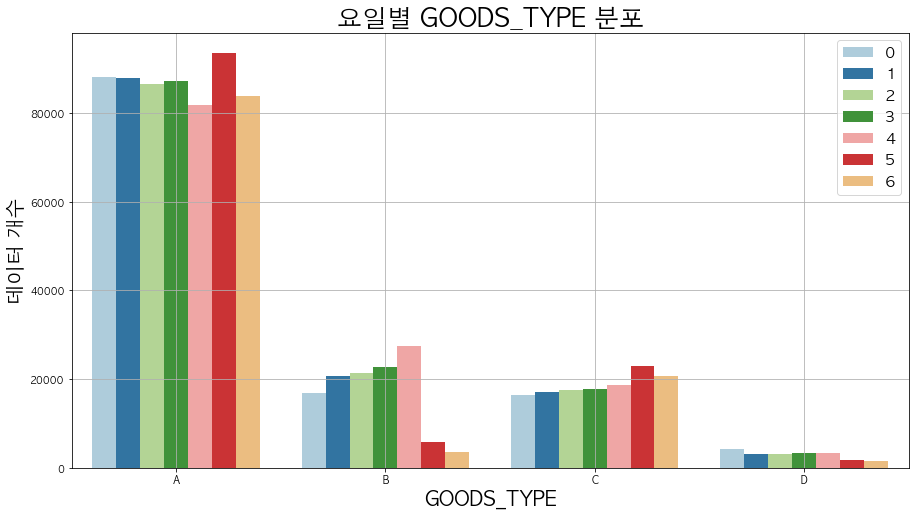

In [13]:
fig, ax = plt.subplots(1,1, figsize = (15, 8))
sns.set_palette("Paired", 9)
sns.countplot(x  = 'GOODS_TYPE', hue = 'dayOFweek', data = df, order=['A', 'B', 'C', 'D'])
plt.grid()
plt.title('요일별 GOODS_TYPE 분포', fontsize=25, fontweight = 'bold')
plt.ylabel('데이터 개수', fontsize=20, fontweight = 'bold')
plt.xlabel('GOODS_TYPE', fontsize=20, fontweight = 'bold')

plt.legend(prop={'size': 15})
fig.show()

#### - GOODS_TYPE의 상품 분류
- A 시간권 
- B 공유주차장
- C 평일/휴일 주간권, 야간권, 당일권
- D 월주차

#### - 분류 기준

요일별 GOODS_TYPE의 분포를 살펴보면, 
1. A타입의 사용자가 가장 많았음. 
일반적으로 주차장을 이용할때, 타지에서 필요한 시간만큼 결제해 주차하는 패턴이 많을 것으로 생각하여 A타입은 모든 [시간권 결제 유형]으로 선정

2. B타입의 경우 주중에 비해 주말과 공휴일의 이용이 현저히 떨어짐. 
공유 주차장의 경우 주중 일과시간동안 자신의 주차구역을 판매하는 패턴이 많을 것으로 생각하여 주말에는 공급이 떨어진다고 판단 B타입을 [공유주차장 상품]으로 선정

3. C타입은 평일/휴일 모두 비교적 비슷한 사용량을 보이며, A타입에 비해 그 이용량이 현저히 떨어짐. 
대게 타지에서 주차장 이용시 필요한 시간만 이용하고 떠나기 마련인데, 어떠한 이유로 종일 주차를 이용할 때가 있음. 이러한 상황을 고려 C타입은 하루를 기준으로 시간권보다는 길게 사용하는 [평일/휴일 주간권, 야간권, 당일권]에 해당할 것으로 판단

4. D타입의 경우 다른 타입에 비교하여 데이터 수가 절대적으로 낮음.
가장 이용자가 적으로 것으로 판단되며, 한번에 결제해야하는 금액도 가장 비싼 [월주차]에 해당할 것으로 예상

### 3-3. 논리적으로 나눈 A,B,C,D GOODS_TYPE에 가격 매칭

In [54]:
df = pd.read_csv("./과제/실전db_after_2013.csv")

In [55]:
df.drop(['Unnamed: 0',"JOIN_YNM","JOIN_YEAR","D_TYPE","STORE_ID","AD1"], axis=1, inplace=True)

In [56]:
display(df.head())

,USER_ID,JOIN_DATE,GOODS_TYPE,DATE,COUNT
0,2858,2014-01-07,A,2020-01-01,1
1,5647,2014-02-14,A,2020-01-01,1
2,33314,2014-11-20,A,2020-01-01,1
3,37001,2014-12-04,C,2020-01-01,1
4,37819,2014-12-07,C,2020-01-01,1


In [57]:
# GOODS_TYPE에 따른 값 분류

goods_list = sorted(df['GOODS_TYPE'].unique()) # A, B, C, D
price_list = [9018.16, 1182.2, 7376.125, 139353.8] # 


new_list = []
for x in range(len(df)):
    if df['GOODS_TYPE'].loc[x] == goods_list[0] :
        new_list.append(price_list[0])
    elif df['GOODS_TYPE'].loc[x] == goods_list[1] :
        new_list.append(price_list[1])
    elif df['GOODS_TYPE'].loc[x] == goods_list[2] :
        new_list.append(price_list[2])
    else :
        new_list.append(price_list[3])
        


In [58]:
# 컬럼 설정
df['PRICE'] = new_list
display(df)

,USER_ID,JOIN_DATE,GOODS_TYPE,DATE,COUNT,PRICE
0,2858,2014-01-07,A,2020-01-01,1,9018.160
1,5647,2014-02-14,A,2020-01-01,1,9018.160
2,33314,2014-11-20,A,2020-01-01,1,9018.160
3,37001,2014-12-04,C,2020-01-01,1,7376.125
4,37819,2014-12-07,C,2020-01-01,1,7376.125
...,...,...,...,...,...,...
878173,1830551,2020-12-31,B,2020-12-31,1,1182.200
878174,1830570,2020-12-31,B,2020-12-31,1,1182.200
878175,1830580,2020-12-31,B,2020-12-31,1,1182.200
878176,1830589,2020-12-31,B,2020-12-31,1,1182.200


In [59]:
#df.to_csv("price_column_added.csv")

### 3-4 Monetary 컬럼 생성

In [60]:
df_M = pd.read_csv("price_column_added.csv")

In [62]:
df_M.head()

,Unnamed: 0,USER_ID,JOIN_DATE,GOODS_TYPE,DATE,COUNT,PRICE
0,0,2858,2014-01-07,A,2020-01-01,1,9018.160
1,1,5647,2014-02-14,A,2020-01-01,1,9018.160
2,2,33314,2014-11-20,A,2020-01-01,1,9018.160
3,3,37001,2014-12-04,C,2020-01-01,1,7376.125
4,4,37819,2014-12-07,C,2020-01-01,1,7376.125


In [63]:
df_M.drop(["Unnamed: 0"], axis=1,inplace=True)

In [ ]:
# df_M.drop(["Unnamed: 0","STORE_ID","D_TYPE","JOIN_DATE","AD1"], axis=1,inplace=True)

In [64]:
df_M["DATE"]= pd.to_datetime(df_M["DATE"])

In [65]:
temp1 = df_M.copy()

In [66]:
temp1.head()

,USER_ID,JOIN_DATE,GOODS_TYPE,DATE,COUNT,PRICE
0,2858,2014-01-07,A,2020-01-01,1,9018.160
1,5647,2014-02-14,A,2020-01-01,1,9018.160
2,33314,2014-11-20,A,2020-01-01,1,9018.160
3,37001,2014-12-04,C,2020-01-01,1,7376.125
4,37819,2014-12-07,C,2020-01-01,1,7376.125


In [67]:
temp1.drop(["DATE","GOODS_TYPE"],axis=1,inplace=True)

In [68]:
#두 열을 곱하자
def product_two_obj(a,b):
    return a * b

In [69]:
temp1["cost_per_unit"] = temp1.apply(lambda x : product_two_obj(x['COUNT'], x['PRICE']), axis=1)

In [70]:
grouped = temp1.groupby("USER_ID")

In [71]:
monetary_df = grouped["cost_per_unit"].sum().round(1).to_frame()

In [72]:
monetary_df.rename(columns={"cost_per_unit":"Monetary"}, inplace=True)

In [73]:
monetary_df.reset_index(inplace=True)

In [74]:
monetary_df.describe()

,USER_ID,Monetary
count,1.651610e+05,1.651610e+05
mean,1.264127e+06,5.850624e+04
std,4.348869e+05,3.191683e+05
min,2.240000e+02,1.182200e+03
25%,9.595580e+05,9.018200e+03
50%,1.412601e+06,1.256480e+04
75%,1.608616e+06,3.688060e+04
max,1.830598e+06,1.096150e+08


#### 1억 이상 쓴 UserID drop! 엔지니어링 팀과 동일하게 이상치 발견함

In [75]:
monetary_df[monetary_df["Monetary"] == 109615043.90]

,USER_ID,Monetary
44065,999665,109615043.9


In [76]:
monetary_df.drop(44115,axis=0,inplace=True)

In [77]:
rfm_df = pd.merge(recency_df, frequency_df, how="left", on="USER_ID")
rfm_df = pd.merge(rfm_df,monetary_df,how='left',on='USER_ID')

In [78]:
rfm_df

,USER_ID,Recency,Frequency,Monetary
0,224,2020-12-09,2,16394.3
1,232,2020-11-18,23,190537.5
2,342,2020-10-31,1,9018.2
3,565,2020-11-12,2,8558.3
4,729,2020-09-05,1,9018.2
...,...,...,...,...
165156,1830551,2020-12-31,1,1182.2
165157,1830570,2020-12-31,1,1182.2
165158,1830580,2020-12-31,1,1182.2
165159,1830589,2020-12-31,1,1182.2


## 4. RFM 테이블 생성

In [79]:
rfm_df["Recency"] = pd.to_datetime(rfm_df['Recency'], format = '%Y-%m-%d' )

In [80]:
current_day = pd.to_datetime('20200101') ## 기준 날짜를 2011년 1월 1일 0시 0분으로 잡았다.
time_diff = rfm_df['Recency']-current_day ## 최근방문일과 기준 날짜의 시간 차이
time_in_seconds = [x.total_seconds() for x in time_diff]
rfm_df['Recency'] = time_in_seconds

In [81]:
rfm_df["Monetary"].isnull().sum()

1

In [82]:
rfm_df.dropna(axis=0, inplace=True)

In [83]:
def get_score(level, data):
    '''
    Description :
    level안에 있는 원소를 기준으로
    1 ~ len(level)+ 1 까지 점수를 부여하는 함수
    
    Parameters :
    level = 튜플 또는 리스트 타입의 숫자형 데이터이며 반드시 오름차순으로 정렬되어 있어야함.
    예 - [1,2,3,4,5] O, [5,4,3,2,1] X, [1,3,2,10,4] X 
    data = 점수를 부여할 데이터. 순회가능한(iterable) 데이터 형식
    return :
    점수를 담고 있는 리스트 반환
    '''
    score = [] 
    for j in range(len(data)): 
        for i in range(len(level)): 
            if data[j] <= level[i]: 
                score.append(i+1) 
                break 
            elif data[j] > max(level): 
                score.append(len(level)+1) 
                break 
            else: 
                continue 
    return score

In [84]:
def get_rfm_grade(df, num_class, rfm_tick_point, rfm_col_map, suffix=None):
    '''
    Description :
    개별 고객에 대한 최근방문일/방문횟수/구매금액 데이터가 주어졌을때
    최근방문일/방문횟수/구매금액 점수를 계산하여 주어진 데이터 오른쪽에 붙여줍니다.
    
    Parameters :
    df = pandas.DataFrame 데이터
    num_class = 등급(점수) 개수
    rfm_tick_point = 최근방문일/방문횟수/구매금액에 대해서 등급을 나눌 기준이 되는 값
                    'quantile', 'min_max' 또는 리스트를 통하여 직접 값을 정할 수 있음.
                    단, 리스트 사용시 원소의 개수는 반드시 num_class - 1 이어야함.
                    quatile = 데이터의 분위수를 기준으로 점수를 매김
                    min_max = 데이터의 최소값과 최대값을 동일 간격으로 나누어 점수를 매김
    rfm_col_map = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명
    예 - {'R':'Recency','F':'Frequency','M':'Monetary'}
    suffix = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명 뒤에 붙는 접미사
    Return : 
    pandas.DataFrame
    '''
    ##### 필요모듈 체크
    import pandas as pd
    import numpy as np
    from sklearn import preprocessing
    
    ##### 파라미터 체크
    if not isinstance(df, pd.DataFrame): ## 데이터는 pd.DataFrame이어야 함.
        print('데이터는 pandas.DataFrame 객체여야 합니다.')
        return
    
    if isinstance(rfm_tick_point, dict) == False or isinstance(rfm_col_map, dict) == False: ## rfm_tick_point와 rfm_col_map은 모두 딕셔너리
        print(f'rfm_tick_point와 rfm_col_map은 모두 딕셔너리여야합니다.')
        return
    
    if len(rfm_col_map) != 3: ## rfm_col_map에는 반드시 3개의 키를 가져아함.
        print(f'rfm_col_map인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if len(rfm_tick_point) != 3: ## rfm_tick_point에는 반드시 3개의 키를 가져아함.
        print(f'rfm_tick_point인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if set(rfm_tick_point.keys()) != set(rfm_col_map.keys()): ## rfm_tick_point와 rfm_col_map은 같은 키를 가져야함.
        print(f'rfm_tick_point와 rfm_col_map은 같은 키를 가져야 합니다.')
        return
    
    if not set(rfm_col_map.values()).issubset(set(df.columns)):
        not_in_df = set(rfm_col_map.values())-set(df.columns)
        print(f'{not_in_df}이 데이터 칼럼에 있어야 합니다.')
        return
    
    for k, v in rfm_tick_point.items():
        if isinstance(v, str):
            if not v in ['quantile','min_max']:
                print(f'{k}의 값은 "quantile" 또는 "min_max"중에 하나여야 합니다.')
                return
        elif isinstance(v,list) or isinstance(v,tuple):
            if len(v) != num_class-1:
                print(f'{k}에 대응하는 리스트(튜플)의 원소는 {num_class-1}개여야 합니다.')
                return
    
    if suffix:
        if not isinstance(suffix, str):
            print('suffix인자는 문자열이어야합니다.')
            return
        
    ##### 최근방문일/방문횟수/구매금액 점수 부여
    for k, v in rfm_tick_point.items():
        if isinstance(v,str):
            if v == 'quantile':
                ## 데이터 변환
                scale = preprocessing.StandardScaler() ## 데이터의 범위 조작하기 쉽게 해주는 클래스 
                temp_data = np.array(df[rfm_col_map[k]]) ## 데이터를 Numpy 배열로 변환
                temp_data = temp_data.reshape((-1,1)) ## scale을 적용하기위해 1차원 배열을 2차원으로 변환
                temp_data = scale.fit_transform(temp_data) ## 데이터를 평균은 0, 표준편차는 1을 갖도록 변환 
                temp_data = temp_data.squeeze() ## 데이터를 다시 1차원으로 변환
 
                ## 분위수 벡터
                quantiles_level = np.linspace(0,1,num_class+1)[1:-1] ## 분위수를 구할 기준값을 지정 0과 1은 제외
                quantiles = [] ## 분위수를 담을 리스트
                for ql in quantiles_level:
                    quantiles.append(np.quantile(temp_data,ql)) ## 분위수를 계산하고 리스트에 삽입

                    
                    
            else: ## min_max인 경우
                ## 데이터 변환
                temp_data = np.array(df[rfm_col_map[k]])
 
                ## 등분점 계산
                quantiles = np.linspace(np.min(temp_data),np.max(temp_data),num_class+1)[1:-1] ## 최소값과 최대값을 점수 개수만큼 등간격으로 분할하는 점
        
        
        
        
        else: ## 직접 구분값을 넣어주는 경우
            temp_data = np.array(df[rfm_col_map[k]])
            quantiles = v ## 직접 구분값을 넣어줌
            
        score = get_score(quantiles, temp_data) ## 구분값을 기준으로 점수를 부여하고 리스트로 저장한다.
        new_col_name = rfm_col_map[k]+'_'+k ## 점수값을 담는 변수의 이름
        
        
        
        
        if suffix:
            new_col_name = rfm_col_map[k]+'_'+suffix
            
        df[new_col_name] = score ## 기존데이터 옆에 점수 데이터를 추가한다.
    return df

In [85]:
rfm_tick_point={'R':'quantile','F':'quantile','M':'quantile'}
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}

RFM_Result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
#result.to_csv('RFM_Result.csv',index=False)

In [86]:
display(RFM_Result)

,USER_ID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M
0,224,29635200.0,2,16394.3,5,3,3
1,232,27820800.0,23,190537.5,4,5,5
2,342,26265600.0,1,9018.2,4,1,2
3,565,27302400.0,2,8558.3,4,3,2
4,729,21427200.0,1,9018.2,3,1,2
...,...,...,...,...,...,...,...
165156,1830551,31536000.0,1,1182.2,5,1,1
165157,1830570,31536000.0,1,1182.2,5,1,1
165158,1830580,31536000.0,1,1182.2,5,1,1
165159,1830589,31536000.0,1,1182.2,5,1,1


In [87]:
RFM_Result["Total_Score"] = RFM_Result["Recency_R"] + RFM_Result["Frequency_F"] + RFM_Result["Monetary_M"] 

In [88]:
RFM_Result.sort_values(by = "Total_Score", ascending=False, inplace = True)

In [89]:
RFM_Result

,USER_ID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M,Total_Score
48868,1066130,31276800.0,11,58377.9,5,5,5,15
158937,1784835,31104000.0,31,279563.0,5,5,5,15
82811,1414384,30844800.0,29,652533.6,5,5,5,15
14003,546209,31276800.0,12,238553.6,5,5,5,15
61059,1206673,30240000.0,19,169243.2,5,5,5,15
...,...,...,...,...,...,...,...,...
56323,1154702,5184000.0,1,7376.1,1,1,1,3
75273,1347634,3888000.0,1,7376.1,1,1,1,3
106657,1538081,8467200.0,1,1182.2,1,1,1,3
106656,1538080,8467200.0,1,7376.1,1,1,1,3


In [90]:
RFM_Result["Total_Score"].value_counts().sort_values(ascending=False)

4     19617
5     15566
7     15293
6     14103
11    13306
13    12662
15    12309
8     11562
10    11372
12    11338
9     10506
3     10408
14     7118
Name: Total_Score, dtype: int64

In [91]:
RFM_Result["RF"] = RFM_Result["Recency_R"] + RFM_Result["Frequency_F"]

In [92]:
RFM_Result

,USER_ID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M,Total_Score,RF
48868,1066130,31276800.0,11,58377.9,5,5,5,15,10
158937,1784835,31104000.0,31,279563.0,5,5,5,15,10
82811,1414384,30844800.0,29,652533.6,5,5,5,15,10
14003,546209,31276800.0,12,238553.6,5,5,5,15,10
61059,1206673,30240000.0,19,169243.2,5,5,5,15,10
...,...,...,...,...,...,...,...,...,...
56323,1154702,5184000.0,1,7376.1,1,1,1,3,2
75273,1347634,3888000.0,1,7376.1,1,1,1,3,2
106657,1538081,8467200.0,1,1182.2,1,1,1,3,2
106656,1538080,8467200.0,1,7376.1,1,1,1,3,2


In [93]:
RFM_Result["RF"].value_counts().sort_values(ascending=False)

2     23223
5     21825
6     21049
4     19027
3     17890
8     17376
7     16487
9     14887
10    13396
Name: RF, dtype: int64

<AxesSubplot:xlabel='Total_Score', ylabel='count'>

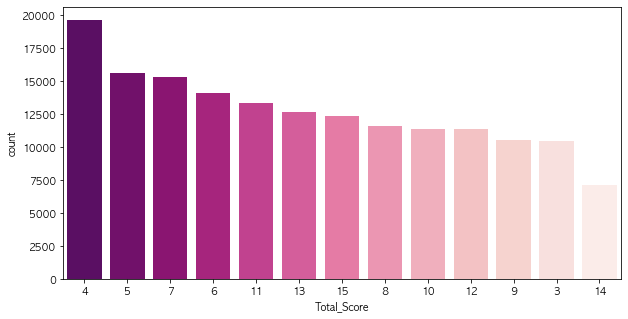

In [94]:
fig = plt.figure(figsize=(10,5)) 
sns.countplot(
    x='Total_Score', 
    data=RFM_Result,
    order = RFM_Result['Total_Score'].value_counts().index,
    palette="RdPu_r")

# (추가3) 지선님 15점 분석 코드 삽입

# 인싸이트 (이 부분을 내일 1시에 2가지로 나누면 됩니다. 결과 분석, Action Plan 제시)
- 모두의 주차장에서 실전db를 제공받았지만 가격에 대한 데이터는 없었고 각 컬럼에대한 설명이 없어서 EDA를 하며 각 컬럼을 유추했다. 우리가 유추한 바로는 실전 db에서의 Goods_Type컬럼은 상품군이라고 판단했다. 
- RFM분석을 하기위해 Monetary에 대한 데이터가 필요했고 우리팀은 Query를 모두의 주차장 서버에 날려 정보를 구할 수 없었기 때문에 직접 APP에서 데이터를 수기로 작성하자고 회의했다. 정확하지는 않지만 일정의 기준을 세우고 데이터를 취합하면 패턴이 보일거라고 판단했다. 
    - 우리의 기준은 서울 지하철역이였다. 모두의 주차장 검색창에 서울시 지하철역을 검색하고 그 지하철역 부근의 주차장 가격을 수집하기 시작했다. 
- 훨씬 많은 주차 상품군이 많았지만 우리가 대략 모은 컬럼은 아래와 같다. 
    - 평일당일권	 , 2시간권	 , 3시간권	,  4시간권	,  평일5시간권  ,    12시간권  ,	주간권 ,	공유  , 주차장	,  월주차	, 평일심야권
- 모두의 주차장의 트레이드마크는 공유 주차장으로 생각됨. 내 집 앞에 거주자 전용 주차구역을 판매할 수 있다는 것인데, 에어비앤비와 같이 공유 경제를 앞세운 전략으로 풀이. 그렇다면 회사 상품 타입에 공유 주차장 카테고리가 따로 있지 않을까 생각이 들어 아래와 같이 Goods_Type이 분류되지 않을까 가설을 세웠다.
    - A 시간권 
    - B 공유주차장
    - C 평일/휴일 주간권, 야간권, 당일권
    - D. 월주차
- 그리하여 RFM을 구했고 결과는 15점만점중 4점,5점,7점,6점의 고객이 대부분이었다. 
- 산업에 따라 다르고 (게임 산업은 2%의 유저가 회사의 매출을 올린다.)주차장에대한 도메인 지식이 좀 더 필요할 수 도 있지만, 모두의 주차장 건강 고객 분류가 15점만점에서 4점,5점,7점,6점이 1-4위를 기록했다. 기존의 높은 점수를 받은 고객은 (여러 고객이 같은 높은 점수를 받았더라도 좀 더 세밀히 분석할 필요가 있다. 만약 총점이 12점이라도 Recency가 낮은 12점이라면 예전에 모두의 주차장을 애용했던 고객이지만 최근 이탈했다고 볼 수 있기 때문이다. 새로운 고객을 얻는것보다 이렇게 중간에 떠난 고객을 좀 더 정성적으로 관리한는것이 매출에 도움이 된다고 판단된다.) 유지할 수 있도록 노력하되 1-4위의 파이를 줄이기 위한 치열한 회의가 필요하다고 판단한다.